In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [ ]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [ ]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

In [ ]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='3'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=2,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/",
    project_name="breakfast-split-2",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

In [ ]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

In [28]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = np.load("/home/dipika16/ar/TimestampActionSeg/data/breakfast_annotation_all.npy", allow_pickle=True).item()
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [11]:
loaded_mean_var_actions = pickle.load(open("dump_dir/mean_var_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[cur_class]
    mean_class = mean_class * 10
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [12]:
prob_video_each_segment_dict = {}

In [16]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele.item())

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [17]:
selected_frames = torch.tensor([2, 10, 17, 21])
cur_vid_feat = torch.randn((27, 48))
labels = torch.tensor([47, 47, 47, 47, 47, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10])
# print(len(labels))
# probs_all_segs = prob_vals_per_segment_new(selected_frames, cur_vid_feat, labels)
# print(probs_all_segs)



In [18]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [19]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [20]:
def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele + ".txt"]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [21]:
def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [22]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [23]:
def get_single_random(labels_all, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((labels_all.shape[0], labels_all.shape[1]), dtype=torch.long, device=labels_all.device) * (-100)
    for iter_num, labels in enumerate(labels_all):
        cur_vidid = video_ids[iter_num]
        frame_idx_tensor = torch.from_numpy(np.array(loaded_vidid_selected_frames[cur_vidid + ".txt"]))
        boundary_target_tensor[iter_num, frame_idx_tensor] = labels[frame_idx_tensor]

    return boundary_target_tensor

In [24]:
model.load_state_dict(torch.load(f"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/"
                            f"/results/em-maximize-mstcn-speed/ms-tcn-em.wt"))

<All keys matched successfully>

In [25]:
initialize_epoch = 15
expectation_cal_gap = 5
for epoch in range(15, 1000):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        boundary_target_tensor = get_single_random(item_2, item[4])
        
        loss = 0
        for p in predictions:
            if epoch <= initialize_epoch:
                loss += ce_criterion(p, boundary_target_tensor)
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4], item_2)
                loss += es_loss
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")
                
    # Calculating Expectation Step
    model.eval()
    if (epoch >= initialize_epoch) and (epoch % expectation_cal_gap == 0):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                calculate_element_probb(prob, item_1, item[4], item_2)
                
                if i % 10 == 0:
#                     pred = torch.argmax(prob, dim=2)
#                     correct += float(torch.sum((pred == item_2) * src_mask).item())
#                     total += float(torch.sum(src_mask).item())
                    print(f"Epoch {epoch} iter {i}")
                    
#         print(f"Epoch {epoch} After Expectation}, train acc. {correct * 100.0 / total: .3f}")
        get_boundary_err()

    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())

    print(f"Validation:: Epoch {epoch}, Probability Accuracy {correct * 100.0 / total}")

Starting Training
Training:: Epoch 15, Iteration 0, Current loss 1.670422911643982 Accuracy 73.96979430055354
Training:: Epoch 15, Iteration 10, Current loss 3.0801100730895996 Accuracy 58.819281458747064
Training:: Epoch 15, Iteration 20, Current loss 1.7788012027740479 Accuracy 81.82924435721296
Training:: Epoch 15, Iteration 30, Current loss 1.8429172039031982 Accuracy 85.61742078497848
Training:: Epoch 15, Iteration 40, Current loss 2.2868900299072266 Accuracy 81.84813539014527
Training:: Epoch 15, Iteration 50, Current loss 1.8934496641159058 Accuracy 67.88126493713415
Training:: Epoch 15, Iteration 60, Current loss 2.0426523685455322 Accuracy 71.8662797187186
Training:: Epoch 15, Iteration 70, Current loss 1.8668643236160278 Accuracy 77.62562245359891
Training:: Epoch 15, Iteration 80, Current loss 1.5906909704208374 Accuracy 71.88582617864137
Training:: Epoch 15, Iteration 90, Current loss 1.8404302597045898 Accuracy 77.0093062605753
Training:: Epoch 15, Iteration 100, Current l

Training:: Epoch 20, Iteration 20, Current loss 1.5950919590826729 Accuracy 84.01692183722804
Training:: Epoch 20, Iteration 30, Current loss 2.257718784381489 Accuracy 82.91512915129151
Training:: Epoch 20, Iteration 40, Current loss 1.6229423470471473 Accuracy 85.77956090493703
Training:: Epoch 20, Iteration 50, Current loss 1.3555144079187214 Accuracy 86.75067286518228
Training:: Epoch 20, Iteration 60, Current loss 1.848327540206294 Accuracy 87.94089439846553
Training:: Epoch 20, Iteration 70, Current loss 1.0717349031110714 Accuracy 75.06997742663657
Training:: Epoch 20, Iteration 80, Current loss 2.9854681166418247 Accuracy 74.48166918975843
Training:: Epoch 20, Iteration 90, Current loss 6.245092963307808 Accuracy 56.169212690951824
Training:: Epoch 20, Iteration 100, Current loss 6.968438760675304 Accuracy 49.06951010964692
Training:: Epoch 20, Iteration 110, Current loss 4.8866111408705875 Accuracy 71.38347407465866
Training:: Epoch 20, Iteration 120, Current loss 2.9865596980

Training:: Epoch 25, Iteration 40, Current loss 2.5312993565891833 Accuracy 78.37801427994073
Training:: Epoch 25, Iteration 50, Current loss 3.195208930002285 Accuracy 72.98185874478952
Training:: Epoch 25, Iteration 60, Current loss 2.9900177670297485 Accuracy 76.9878645172976
Training:: Epoch 25, Iteration 70, Current loss 1.7160447624257638 Accuracy 86.2463465553236
Training:: Epoch 25, Iteration 80, Current loss 0.996588885814818 Accuracy 87.77173913043478
Training:: Epoch 25, Iteration 90, Current loss 1.6816926349983876 Accuracy 86.94635287238708
Training:: Epoch 25, Iteration 100, Current loss 2.5123365974684484 Accuracy 77.78845164167839
Training:: Epoch 25, Iteration 110, Current loss 1.812848368214991 Accuracy 79.31682062734748
Training:: Epoch 25, Iteration 120, Current loss 1.2014691446116585 Accuracy 90.22138228941685
Training:: Epoch 25, Iteration 130, Current loss 1.8208205290658688 Accuracy 89.35926773455378
Training:: Epoch 25, Iteration 140, Current loss 1.1434124018

Training:: Epoch 30, Iteration 60, Current loss 0.6208609048087266 Accuracy 87.13141158007764
Training:: Epoch 30, Iteration 70, Current loss 0.7330033965763171 Accuracy 93.33333333333333
Training:: Epoch 30, Iteration 80, Current loss 1.8539204349957608 Accuracy 79.97928616953473
Training:: Epoch 30, Iteration 90, Current loss 0.9291879529168985 Accuracy 87.07854703508227
Training:: Epoch 30, Iteration 100, Current loss 1.7716795745872784 Accuracy 82.11601605253557
Training:: Epoch 30, Iteration 110, Current loss 1.2931347948299299 Accuracy 87.60825267447784
Training:: Epoch 30, Iteration 120, Current loss 2.3502022095705604 Accuracy 83.67242263634809
Training:: Epoch 30, Iteration 130, Current loss 3.776045247477245 Accuracy 82.92918274878335
Training:: Epoch 30, Iteration 140, Current loss 1.2601718438290876 Accuracy 87.70328321571034
Training:: Epoch 30, Iteration 150, Current loss 1.6770266828991804 Accuracy 84.188117842811
Calculating Expectation
Epoch 30 iter 0
Epoch 30 iter 10


Training:: Epoch 35, Iteration 80, Current loss 0.7690584562697579 Accuracy 85.46600783779179
Training:: Epoch 35, Iteration 90, Current loss 0.8066140539751923 Accuracy 88.57938718662953
Training:: Epoch 35, Iteration 100, Current loss 0.523616942755202 Accuracy 87.419802897017
Training:: Epoch 35, Iteration 110, Current loss 0.7822710170769791 Accuracy 83.6897458369851
Training:: Epoch 35, Iteration 120, Current loss 0.6280725443669178 Accuracy 88.9962776725658
Training:: Epoch 35, Iteration 130, Current loss 0.9864560823001924 Accuracy 85.34528202424882
Training:: Epoch 35, Iteration 140, Current loss 0.8730031862086447 Accuracy 83.45832440539961
Training:: Epoch 35, Iteration 150, Current loss 0.6944059660152636 Accuracy 89.4199535962877
Calculating Expectation
Epoch 35 iter 0
Epoch 35 iter 10
Epoch 35 iter 20
Epoch 35 iter 30
Epoch 35 iter 40
Epoch 35 iter 50
Epoch 35 iter 60
Epoch 35 iter 70
Epoch 35 iter 80
Epoch 35 iter 90
Epoch 35 iter 100
Epoch 35 iter 110
Epoch 35 iter 120
E

Training:: Epoch 40, Iteration 90, Current loss 0.45145674230340094 Accuracy 87.57180410865544
Training:: Epoch 40, Iteration 100, Current loss 0.5459233641583536 Accuracy 90.53144432335407
Training:: Epoch 40, Iteration 110, Current loss 0.5033786748390967 Accuracy 87.6417004048583
Training:: Epoch 40, Iteration 120, Current loss 0.6794927866224445 Accuracy 87.14568599717114
Training:: Epoch 40, Iteration 130, Current loss 0.7098937502665462 Accuracy 86.96827337666517
Training:: Epoch 40, Iteration 140, Current loss 0.33839786410726574 Accuracy 83.66160800774944
Training:: Epoch 40, Iteration 150, Current loss 0.5793675587613307 Accuracy 83.89290267743307
Calculating Expectation
Epoch 40 iter 0
Epoch 40 iter 10
Epoch 40 iter 20
Epoch 40 iter 30
Epoch 40 iter 40
Epoch 40 iter 50
Epoch 40 iter 60
Epoch 40 iter 70
Epoch 40 iter 80
Epoch 40 iter 90
Epoch 40 iter 100
Epoch 40 iter 110
Epoch 40 iter 120
Epoch 40 iter 130
Epoch 40 iter 140
Epoch 40 iter 150
Train Boundary avergage error = 86

Training:: Epoch 45, Iteration 100, Current loss 2.383732011042988 Accuracy 77.76865671641791
Training:: Epoch 45, Iteration 110, Current loss 4.3915302026878 Accuracy 67.18991819588769
Training:: Epoch 45, Iteration 120, Current loss 2.539319524138533 Accuracy 74.8145780051151
Training:: Epoch 45, Iteration 130, Current loss 0.912827850895422 Accuracy 88.75427969449565
Training:: Epoch 45, Iteration 140, Current loss 1.5961718944810745 Accuracy 85.89014706573322
Training:: Epoch 45, Iteration 150, Current loss 2.3707689129501754 Accuracy 83.81936754029778
Calculating Expectation
Epoch 45 iter 0
Epoch 45 iter 10
Epoch 45 iter 20
Epoch 45 iter 30
Epoch 45 iter 40
Epoch 45 iter 50
Epoch 45 iter 60
Epoch 45 iter 70
Epoch 45 iter 80
Epoch 45 iter 90
Epoch 45 iter 100
Epoch 45 iter 110
Epoch 45 iter 120
Epoch 45 iter 130
Epoch 45 iter 140
Epoch 45 iter 150
Train Boundary avergage error = 107.241
Train From boundary avergage accuracy = 86.719
Calculating Validation Data Accuracy
Validation::

Training:: Epoch 50, Iteration 120, Current loss 0.5676703608273411 Accuracy 85.3167997282147
Training:: Epoch 50, Iteration 130, Current loss 0.9161217586491471 Accuracy 83.50650833523636
Training:: Epoch 50, Iteration 140, Current loss 0.5953239997056018 Accuracy 91.88800060622134
Training:: Epoch 50, Iteration 150, Current loss 1.1427137101611413 Accuracy 90.21669853409816
Calculating Expectation
Epoch 50 iter 0
Epoch 50 iter 10
Epoch 50 iter 20
Epoch 50 iter 30
Epoch 50 iter 40
Epoch 50 iter 50
Epoch 50 iter 60
Epoch 50 iter 70
Epoch 50 iter 80
Epoch 50 iter 90
Epoch 50 iter 100
Epoch 50 iter 110
Epoch 50 iter 120
Epoch 50 iter 130
Epoch 50 iter 140
Epoch 50 iter 150
Train Boundary avergage error = 90.900
Train From boundary avergage accuracy = 87.716
Calculating Validation Data Accuracy
Validation:: Epoch 50, Probability Accuracy 66.27242407921449
Starting Training
Training:: Epoch 51, Iteration 0, Current loss 0.777753574328463 Accuracy 86.32530939752482
Training:: Epoch 51, Iter

Training:: Epoch 55, Iteration 130, Current loss 0.5044805919403474 Accuracy 86.83664649956785
Training:: Epoch 55, Iteration 140, Current loss 0.48355606762209646 Accuracy 86.63170982215254
Training:: Epoch 55, Iteration 150, Current loss 0.4747769260008363 Accuracy 85.07796446271001
Calculating Expectation
Epoch 55 iter 0
Epoch 55 iter 10
Epoch 55 iter 20
Epoch 55 iter 30
Epoch 55 iter 40
Epoch 55 iter 50
Epoch 55 iter 60
Epoch 55 iter 70
Epoch 55 iter 80
Epoch 55 iter 90
Epoch 55 iter 100
Epoch 55 iter 110
Epoch 55 iter 120
Epoch 55 iter 130
Epoch 55 iter 140
Epoch 55 iter 150
Train Boundary avergage error = 89.283
Train From boundary avergage accuracy = 87.981
Calculating Validation Data Accuracy
Validation:: Epoch 55, Probability Accuracy 66.99289472593942
Starting Training
Training:: Epoch 56, Iteration 0, Current loss 0.2871670546486662 Accuracy 91.72409040793826
Training:: Epoch 56, Iteration 10, Current loss 0.3581049207529407 Accuracy 88.57999294698483
Training:: Epoch 56, It

Training:: Epoch 60, Iteration 140, Current loss 0.35752741969521806 Accuracy 89.04635576654566
Training:: Epoch 60, Iteration 150, Current loss 0.4145514901843467 Accuracy 84.35361901332374
Calculating Expectation
Epoch 60 iter 0
Epoch 60 iter 10
Epoch 60 iter 20
Epoch 60 iter 30
Epoch 60 iter 40
Epoch 60 iter 50
Epoch 60 iter 60
Epoch 60 iter 70
Epoch 60 iter 80
Epoch 60 iter 90
Epoch 60 iter 100
Epoch 60 iter 110
Epoch 60 iter 120
Epoch 60 iter 130
Epoch 60 iter 140
Epoch 60 iter 150
Train Boundary avergage error = 89.514
Train From boundary avergage accuracy = 88.093
Calculating Validation Data Accuracy
Validation:: Epoch 60, Probability Accuracy 66.1026639598956
Starting Training
Training:: Epoch 61, Iteration 0, Current loss 0.27843619480179643 Accuracy 90.67197341473782
Training:: Epoch 61, Iteration 10, Current loss 0.2896598137857795 Accuracy 86.55504500535028
Training:: Epoch 61, Iteration 20, Current loss 0.30415290290696323 Accuracy 92.2708686546325
Training:: Epoch 61, Ite

Training:: Epoch 65, Iteration 150, Current loss 0.48898835219414194 Accuracy 89.14039846599944
Calculating Expectation
Epoch 65 iter 0
Epoch 65 iter 10
Epoch 65 iter 20
Epoch 65 iter 30
Epoch 65 iter 40
Epoch 65 iter 50
Epoch 65 iter 60
Epoch 65 iter 70
Epoch 65 iter 80
Epoch 65 iter 90
Epoch 65 iter 100
Epoch 65 iter 110
Epoch 65 iter 120
Epoch 65 iter 130
Epoch 65 iter 140
Epoch 65 iter 150
Train Boundary avergage error = 88.686
Train From boundary avergage accuracy = 88.146
Calculating Validation Data Accuracy
Validation:: Epoch 65, Probability Accuracy 66.4427020756515
Starting Training
Training:: Epoch 66, Iteration 0, Current loss 0.3160044608110207 Accuracy 88.2318532305238
Training:: Epoch 66, Iteration 10, Current loss 0.46172317062539914 Accuracy 84.39847025756808
Training:: Epoch 66, Iteration 20, Current loss 0.41119374378422463 Accuracy 87.42573451615529
Training:: Epoch 66, Iteration 30, Current loss 0.40836165766224686 Accuracy 85.86436498150431
Training:: Epoch 66, Ite

Epoch 70 iter 0
Epoch 70 iter 10
Epoch 70 iter 20
Epoch 70 iter 30
Epoch 70 iter 40
Epoch 70 iter 50
Epoch 70 iter 60
Epoch 70 iter 70
Epoch 70 iter 80
Epoch 70 iter 90
Epoch 70 iter 100
Epoch 70 iter 110
Epoch 70 iter 120
Epoch 70 iter 130
Epoch 70 iter 140
Epoch 70 iter 150
Train Boundary avergage error = 88.328
Train From boundary avergage accuracy = 88.114
Calculating Validation Data Accuracy
Validation:: Epoch 70, Probability Accuracy 66.71655549571197
Starting Training
Training:: Epoch 71, Iteration 0, Current loss 0.384750983694861 Accuracy 89.44513975803088
Training:: Epoch 71, Iteration 10, Current loss 0.5597397720083269 Accuracy 90.02394253790902
Training:: Epoch 71, Iteration 20, Current loss 0.3766035424790004 Accuracy 88.97953129635123
Training:: Epoch 71, Iteration 30, Current loss 0.3773640893371916 Accuracy 87.15775749674054
Training:: Epoch 71, Iteration 40, Current loss 0.36783612872128535 Accuracy 88.62489486963835
Training:: Epoch 71, Iteration 50, Current loss 0.5

Epoch 75 iter 40
Epoch 75 iter 50
Epoch 75 iter 60
Epoch 75 iter 70
Epoch 75 iter 80
Epoch 75 iter 90
Epoch 75 iter 100
Epoch 75 iter 110
Epoch 75 iter 120
Epoch 75 iter 130
Epoch 75 iter 140
Epoch 75 iter 150
Train Boundary avergage error = 88.599
Train From boundary avergage accuracy = 88.104
Calculating Validation Data Accuracy
Validation:: Epoch 75, Probability Accuracy 66.22519368604218
Starting Training
Training:: Epoch 76, Iteration 0, Current loss 0.21168994984716188 Accuracy 90.63797659494149
Training:: Epoch 76, Iteration 10, Current loss 0.39485004098288384 Accuracy 86.4268680445151
Training:: Epoch 76, Iteration 20, Current loss 0.2921516281257057 Accuracy 85.58481410119175
Training:: Epoch 76, Iteration 30, Current loss 0.2892689101975435 Accuracy 91.72328086164043
Training:: Epoch 76, Iteration 40, Current loss 0.21992425206582633 Accuracy 89.4180255168179
Training:: Epoch 76, Iteration 50, Current loss 0.21709144255383858 Accuracy 87.8258960425929
Training:: Epoch 76, It

Epoch 80 iter 70
Epoch 80 iter 80
Epoch 80 iter 90
Epoch 80 iter 100
Epoch 80 iter 110
Epoch 80 iter 120
Epoch 80 iter 130
Epoch 80 iter 140
Epoch 80 iter 150
Train Boundary avergage error = 88.654
Train From boundary avergage accuracy = 88.000
Calculating Validation Data Accuracy
Validation:: Epoch 80, Probability Accuracy 65.27488917429672
Starting Training
Training:: Epoch 81, Iteration 0, Current loss 0.2330535409564874 Accuracy 89.6169275544718
Training:: Epoch 81, Iteration 10, Current loss 0.15883315382201757 Accuracy 90.62750601443464
Training:: Epoch 81, Iteration 20, Current loss 0.20848944252596407 Accuracy 86.54608916389022
Training:: Epoch 81, Iteration 30, Current loss 0.27989775968078395 Accuracy 87.05432937181664
Training:: Epoch 81, Iteration 40, Current loss 0.21295247681617058 Accuracy 88.57832294389705
Training:: Epoch 81, Iteration 50, Current loss 0.28690550970412704 Accuracy 88.05817810665987
Training:: Epoch 81, Iteration 60, Current loss 0.3586388259117707 Accu

Epoch 85 iter 110
Epoch 85 iter 120
Epoch 85 iter 130
Epoch 85 iter 140
Epoch 85 iter 150
Train Boundary avergage error = 89.035
Train From boundary avergage accuracy = 87.876
Calculating Validation Data Accuracy
Validation:: Epoch 85, Probability Accuracy 64.52458880556821
Starting Training
Training:: Epoch 86, Iteration 0, Current loss 0.22979921997095923 Accuracy 77.72362007640628
Training:: Epoch 86, Iteration 10, Current loss 0.418823662934479 Accuracy 84.00129806912219
Training:: Epoch 86, Iteration 20, Current loss 0.27305758797239843 Accuracy 83.02416524616464
Training:: Epoch 86, Iteration 30, Current loss 0.19125765889430205 Accuracy 91.95211960635882
Training:: Epoch 86, Iteration 40, Current loss 0.18319932365248523 Accuracy 87.7996594035195
Training:: Epoch 86, Iteration 50, Current loss 0.19003038121265517 Accuracy 89.64249393726043
Training:: Epoch 86, Iteration 60, Current loss 0.49991598177761754 Accuracy 82.04185058034984
Training:: Epoch 86, Iteration 70, Current los

Epoch 90 iter 150
Train Boundary avergage error = 89.257
Train From boundary avergage accuracy = 87.820
Calculating Validation Data Accuracy
Validation:: Epoch 90, Probability Accuracy 66.51986576625099
Starting Training
Training:: Epoch 91, Iteration 0, Current loss 0.2637809630171982 Accuracy 86.12561425061425
Training:: Epoch 91, Iteration 10, Current loss 0.28875146765706744 Accuracy 88.72478111914732
Training:: Epoch 91, Iteration 20, Current loss 0.21635878924957297 Accuracy 83.37126202738851
Training:: Epoch 91, Iteration 30, Current loss 0.2694709876274435 Accuracy 89.30684987415822
Training:: Epoch 91, Iteration 40, Current loss 0.2757635074683119 Accuracy 88.26577089501252
Training:: Epoch 91, Iteration 50, Current loss 0.29285147740004686 Accuracy 90.3506734788667
Training:: Epoch 91, Iteration 60, Current loss 0.28325551655583625 Accuracy 90.81306990881458
Training:: Epoch 91, Iteration 70, Current loss 0.2133852235415748 Accuracy 89.28231582110482
Training:: Epoch 91, Iter

KeyboardInterrupt: 

In [26]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/ms-tcn-emmax-last-model.wt")

In [22]:
model.load_state_dict(torch.load(f"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/"
                            f"/results/em-maximize-mstcn-speed/ms-tcn-em.wt"))

<All keys matched successfully>

In [29]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Epoch {epoch}, Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Epoch 94, Probability Accuracy 66.43224095786552


In [ ]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [28]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [ ]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

In [29]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[4]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [34]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele + ".txt"]):
        print(ele)

In [35]:
import pickle
# pickle.dump(video_id_boundary_frames, open("dump_dir/video_id_boundary_frames_dict.pkl", "wb"))
# pickle.dump(loaded_vidid_selected_frames, open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "wb"))
pickle.dump(video_id_boundary_frames, open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "wb"))

In [ ]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [ ]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

In [76]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4], item_2)

        if i%10==0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
Train Boundary avergage error = 107.269
Train From boundary avergage accuracy = 87.407


In [77]:
with torch.no_grad():
    idx = 4

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
    
    bound_list = video_id_boundary_frames[cur_vidid]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, item_2[idx])


Min prob 0 = 7.953912266787591e-36
Min prob 1 = 2.7495868628582206e-249
Min prob 2 = 8.185175464823537e-201


(0, 442)

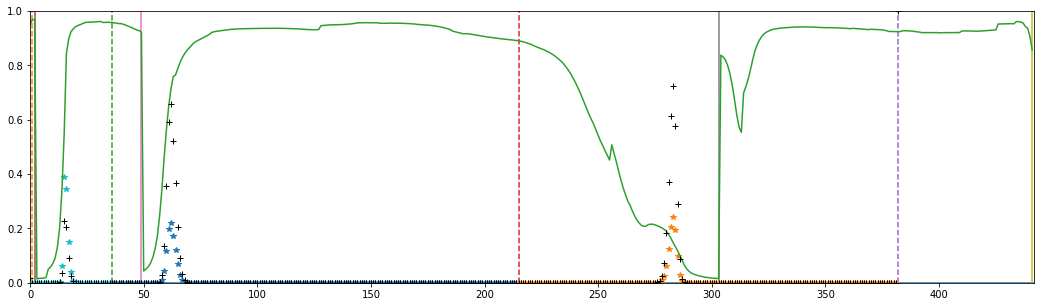

In [78]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid + ".txt"][i], 
                   loaded_vidid_selected_frames[cur_vidid + ".txt"][i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

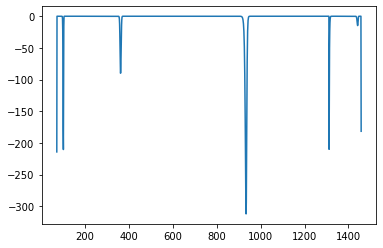

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

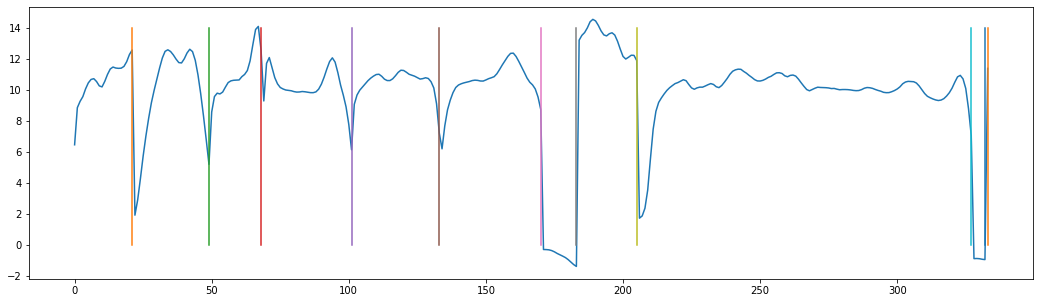

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss